In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import torch
import numpy as np
from blending.utils.dataset import ImageDataBlending
from blending.utils.image import (_pil_image, get_image_laplacian_operator, get_blending_gradients,
                                  get_mixing_gradients, normalize_image)
from blending.utils.plots import plots_multiple_image_data, plots_multiple_tensor_image
from blending import blend
from argparse import Namespace

In [3]:
opt = Namespace(
    data_dir = 'data_blending',
    normalize = True,
    requires_grad = True,
    device = 'cuda'
)

device = torch.device(opt.device)

# Load Data

In [4]:
image_data_blending = ImageDataBlending(opt.data_dir, normalize=opt.normalize, device=device)

Getting Files:   0%|          | 0/4 [00:00<?, ?it/s]

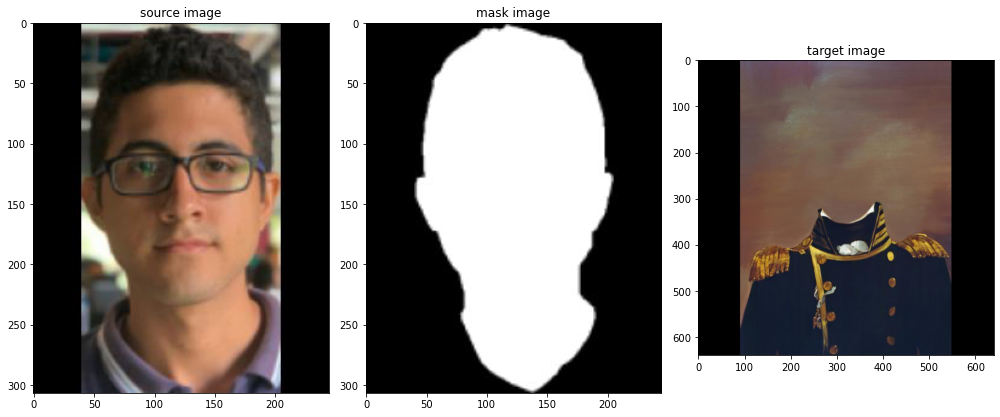

In [5]:
plots_multiple_image_data(image_data_blending[0], normalize=opt.normalize)

# Laplacian Operator

Laplacian operator $\nabla I$ over the image:

$$
\nabla = \begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix}
$$

In order to get the gradients of the images, we are going to define a convolutinal operation using the `laplacian matrix` as the kernel. Then make a convolution between the image, $I$, and the kernel $\nabla$

$$\begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix} \circledast I$$

The following code will calculate each channel's gradients, and present it as plots 

## Gradients of source image

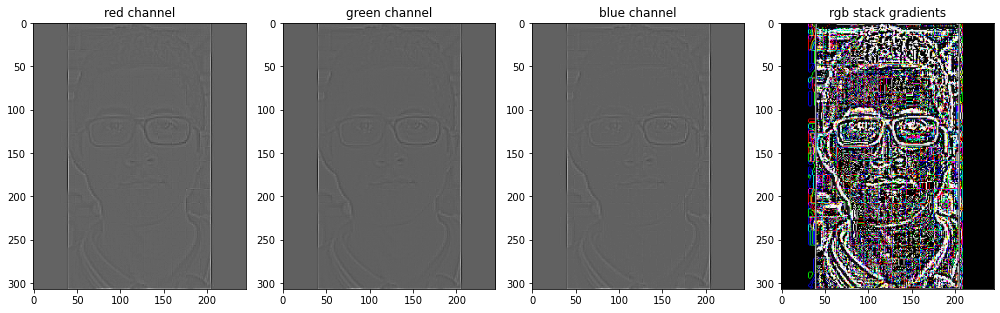

In [7]:
# Show each channel gradient
rgb_gradients_list = get_image_laplacian_operator(image_data_blending[0]['source'].unsqueeze(0), device=device)
rgb_gradients = torch.stack(rgb_gradients_list, dim=2).view(*image_data_blending[0]['source'].shape)
plots_multiple_tensor_image(*rgb_gradients_list, np.asarray(_pil_image(rgb_gradients)),
                            title_name=["red channel", "green channel", "blue channel", "rgb stack gradients"],
                           normalize=opt.normalize)

## Gradients of target image

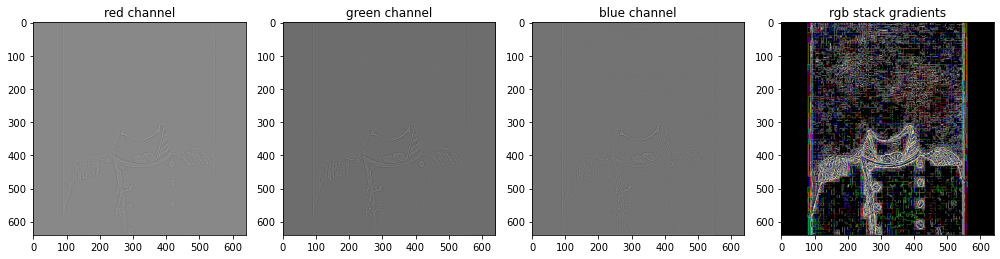

In [8]:
# Show each channel gradient
rgb_gradients_list = get_image_laplacian_operator(image_data_blending[0]['target'].unsqueeze(0), device=device)
rgb_gradients = torch.stack(rgb_gradients_list, dim=2).view(*image_data_blending[0]['target'].shape)
plots_multiple_tensor_image(*rgb_gradients_list, np.asarray(_pil_image(rgb_gradients)),
                            title_name=["red channel", "green channel", "blue channel", "rgb stack gradients"],
                            normalize=opt.normalize)

# Join Gradients

As we are going to blend both images `source` and `target`, we need to mix its gradients in order to optimize the following loss function:

$$L_{grad} = \frac{1}{2HW} \sum_{m=1}^{H}\sum_{n=1}^{W}[\nabla f(I_B) - (\nabla f(I_S) + \nabla f(I_T)]^{2}_{mn}$$

where $f$ is the blending function, $\nabla$ the laplacian operator, $I_S$ the source image and $I_T$ the target image. This loss function is over the gradients that means we are going to create a image such that optimize the previous loss grad

## Content loss function

For this content loss function we are going to use pretrained model VGG on imagenet, and this is define as:

$$L_{cont} = \sum_{l=1}^{L}\frac{\alpha_l}{2N_lM_l}\sum_{i=1}^{N_l}\sum_{k=1}^{M_l}(F_l[I_{Z}]\odot M - F_l[I_{S}])^{2}_{ik}$$

where $I_Z$ is the random Image that we are going to optimize, and $I_S$ is the source image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


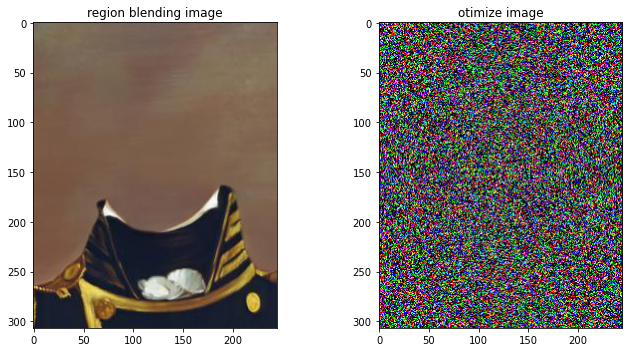

In [14]:
image_data = {
    'source': image_data_blending[0]['source'].unsqueeze(0),
    'target': image_data_blending[0]['target'].unsqueeze(0),
    'dims': image_data_blending[0]['dims'],
    'mask': image_data_blending[0]['mask'].unsqueeze(0)
}

source = image_data['source']
target = image_data['target']
dims = image_data['dims']
mask = image_data['mask']
input_img = torch.randn_like(source, device=device).contiguous()
input_img.requires_grad = opt.requires_grad
tensor_image_target = target[:, :, dims[0]:dims[1], dims[2]:dims[3]] 

# plot tensor image
with torch.no_grad():
    plots_multiple_tensor_image(tensor_image_target, input_img,
                                title_name=["region blending image",
                                            "otimize image"], normalize=opt.normalize, figsize=(10,5))

optimizer = torch.optim.LBFGS([input_img.requires_grad_()], lr=1.5, max_iter=100)
mseLoss = torch.nn.MSELoss().to(device=device)
gt_gradients = torch.stack(get_mixing_gradients(image_data, device=device), dim=2).squeeze(0)

In [10]:
run = [0]
num_step = 4000
lg=1e9

while run[0] < num_step:
    def closure():
        optimizer.zero_grad()
        blend_img = (input_img * mask + tensor_image_target * (1 - mask))
        blend_gradients = torch.stack(get_blending_gradients(image_data, blend_img, device=device), dim=2).squeeze(0)
        grad_loss = lg*mseLoss(blend_gradients, gt_gradients)
        if run[0] == 0:
            print("step: {}, grad_loss : {:.3f}".format(run[0] + 1, grad_loss.item()))
            
        if (run[0] + 1)%200 == 0:
            print("step: {}, grad_loss : {:.3f}".format(run[0] + 1, grad_loss.item()))
        run[0] += 1
        grad_loss.backward()
        return grad_loss
    optimizer.step(closure)

step: 1, grad_loss : 9093849088.000
step: 200, grad_loss : 7769.114
step: 400, grad_loss : 2119.801
step: 600, grad_loss : 1064.755
step: 800, grad_loss : 702.673
step: 1000, grad_loss : 507.390
step: 1200, grad_loss : 395.589
step: 1400, grad_loss : 332.645
step: 1600, grad_loss : 284.505
step: 1800, grad_loss : 248.399
step: 2000, grad_loss : 220.169
step: 2200, grad_loss : 194.105
step: 2400, grad_loss : 172.317
step: 2600, grad_loss : 155.501
step: 2800, grad_loss : 139.806
step: 3000, grad_loss : 127.236
step: 3200, grad_loss : 118.716
step: 3400, grad_loss : 111.590
step: 3600, grad_loss : 105.246
step: 3800, grad_loss : 99.758
step: 4000, grad_loss : 94.439


## Results just using grad loss function

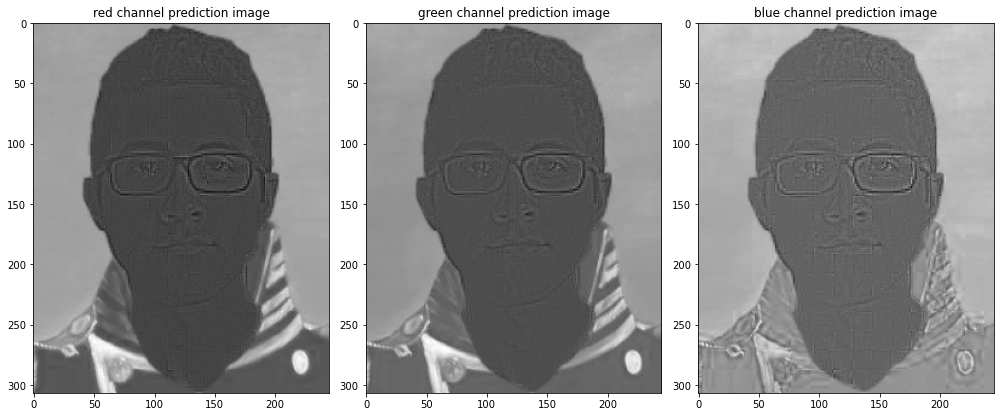

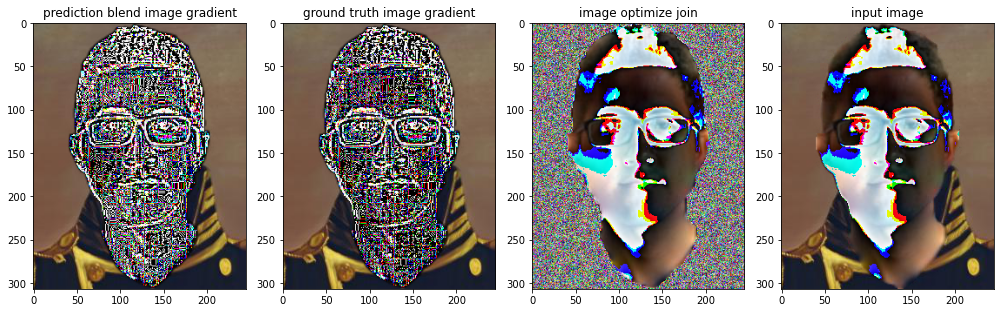

In [11]:
with torch.no_grad():
    blend_img = (input_img * mask + tensor_image_target * (1 - mask))
    blend_gradients = torch.stack(get_blending_gradients(image_data, blend_img, device=device), dim=2).squeeze(0)
    plots_multiple_tensor_image(*[blend_gradients[:, ch, :, :] for ch in range(3)],
                                title_name=["red channel prediction image",
                                           "green channel prediction image",
                                           "blue channel prediction image"], normalize=opt.normalize)
    plots_multiple_tensor_image(np.asarray(_pil_image(blend_gradients)),
                                np.asarray(_pil_image(gt_gradients)),
                                np.asarray(_pil_image(input_img)),
                                np.asarray(_pil_image(blend_img)), 
                                title_name=["prediction blend image gradient",
                                           "ground truth image gradient",
                                           "image optimize join",
                                           "input image"], normalize=opt.normalize)

In [10]:
from torchvision import models
import torch.nn as nn

class MeanShift(nn.Conv2d):
    def __init__(self):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        rgb_range=1
        rgb_mean=(0.4488, 0.4371, 0.4040)
        rgb_std=(1.0, 1.0, 1.0)
        sign=-1
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1) / std.view(3, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean) / std
        for p in self.parameters():
            p.requires_grad = False

meanShift = MeanShift()

## Feature extraction with vgg16

In [11]:
vgg16 = models.vgg16(pretrained=True)

In [12]:
slice1 = nn.Sequential()
slice2 = nn.Sequential()
slice3 = nn.Sequential()
slice4 = nn.Sequential()
slice5 = nn.Sequential()

for x in range(4):
    slice1.add_module(str(x), vgg16.features[x])
for x in range(4, 9):
    slice2.add_module(str(x), vgg16.features[x])
for x in range(9, 16):
    slice3.add_module(str(x), vgg16.features[x])
for x in range(16, 23):
    slice4.add_module(str(x), vgg16.features[x])
for x in range(23, 29):
    slice5.add_module(str(x), vgg16.features[x])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


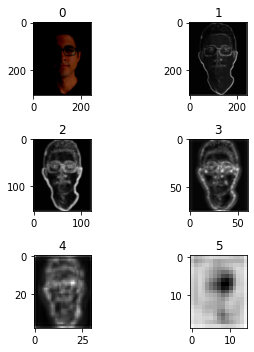

In [18]:
with torch.no_grad():
    mean_shift_img = meanShift(source.cpu() * mask.cpu())
    h_relu1_2 = slice1(mean_shift_img)
    h_relu2_2 = slice2(h_relu1_2)
    h_relu3_3 = slice3(h_relu2_2)
    h_relu4_3 = slice4(h_relu3_3)
    h_relu5_2 = slice5(h_relu4_3)
    
plots_multiple_tensor_image(mean_shift_img,
                            h_relu1_2.mean(dim=1),
                            h_relu2_2.mean(dim=1),
                            h_relu3_3.mean(dim=1),
                            h_relu4_3.mean(dim=1),
                            h_relu5_2.mean(dim=1),
                            ncols=2, figsize=(5, 5))

## Feature extraction with vgg11

In [19]:
vgg11 = models.vgg11(pretrained=True)

In [20]:
slice1_ = nn.Sequential()
slice2_ = nn.Sequential()
slice3_ = nn.Sequential()
slice4_ = nn.Sequential()
slice5_ = nn.Sequential()

for x in range(2):
    slice1_.add_module(str(x), vgg11.features[x])
for x in range(2, 5):
    slice2_.add_module(str(x), vgg11.features[x])
for x in range(5, 10):
    slice3_.add_module(str(x), vgg11.features[x])
for x in range(10, 15):
    slice4_.add_module(str(x), vgg11.features[x])
for x in range(15, 20):
    slice5_.add_module(str(x), vgg11.features[x])

with torch.no_grad():
    mean_shift_img = meanShift(source.cpu() * mask.cpu())
    h_relu1_2 = slice1_(mean_shift_img)
    h_relu2_2 = slice2_(h_relu1_2)
    h_relu3_3 = slice3_(h_relu2_2)
    h_relu4_3 = slice4_(h_relu3_3)
    h_relu5_2 = slice5_(h_relu4_3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


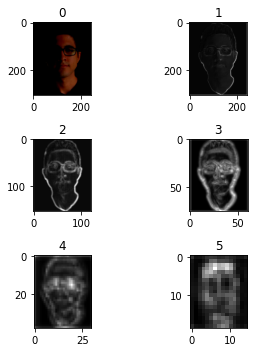

In [21]:
plots_multiple_tensor_image(mean_shift_img,
                            h_relu1_2.mean(dim=1),
                            h_relu2_2.mean(dim=1),
                            h_relu3_3.mean(dim=1),
                            h_relu4_3.mean(dim=1),
                            h_relu5_2.mean(dim=1),
                            ncols=2, figsize=(5, 5))

## Define Loss and Optimizer

In [60]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device=device)
meanShift.to(device=device)

for parameter in vgg16.features.parameters():
    parameter.requires_grad = False
    
slice1 = nn.Sequential()
slice2 = nn.Sequential()
slice3 = nn.Sequential()
slice4 = nn.Sequential()

for x in range(4):
    slice1.add_module(str(x), vgg16.features[x])
for x in range(4, 9):
    slice2.add_module(str(x), vgg16.features[x])
for x in range(9, 16):
    slice3.add_module(str(x), vgg16.features[x])
for x in range(16, 23):
    slice4.add_module(str(x), vgg16.features[x])

def get_vgg16_features(tensor_image):
    normalized_tensor = normalize_image(tensor_image)
    h_relu1_2 = slice1(normalized_tensor)
    h_relu2_2 = slice2(h_relu1_2)
    h_relu3_3 = slice3(h_relu2_2)
    h_relu4_3 = slice4(h_relu3_3)
    return h_relu2_2

In [61]:
vgg11 = models.vgg11(pretrained=True)
vgg11.to(device=device)
meanShift.to(device=device)

for parameter in vgg11.features.parameters():
    parameter.requires_grad = False
    
slice1_ = nn.Sequential()
slice2_ = nn.Sequential()
slice3_ = nn.Sequential()
slice4_ = nn.Sequential()

for x in range(2):
    slice1_.add_module(str(x), vgg11.features[x])
for x in range(2, 5):
    slice2_.add_module(str(x), vgg11.features[x])
for x in range(5, 10):
    slice3_.add_module(str(x), vgg11.features[x])
for x in range(10, 15):
    slice4_.add_module(str(x), vgg11.features[x])

def get_vgg11_features(tensor_image):
    normalized_tensor = normalize_image(tensor_image)
    h_relu1_2 = slice1_(normalized_tensor)
    h_relu2_2 = slice2_(h_relu1_2)
    h_relu3_3 = slice3_(h_relu2_2)
    h_relu4_3 = slice4_(h_relu3_3)
    return h_relu2_2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


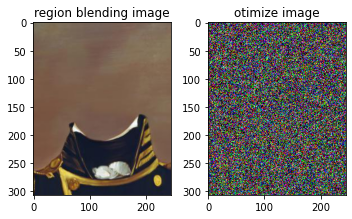

In [62]:
image_data = {
    'source': image_data_blending[0]['source'].unsqueeze(0),
    'target': image_data_blending[0]['target'].unsqueeze(0),
    'dims': image_data_blending[0]['dims'],
    'mask': image_data_blending[0]['mask'].unsqueeze(0)
}

source = image_data['source']
target = image_data['target']
dims = image_data['dims']
mask = image_data['mask']
input_img = torch.randn_like(source, device=device).contiguous()
input_img.requires_grad = opt.requires_grad
tensor_image_target = target[:, :, dims[0]:dims[1], dims[2]:dims[3]] 

# plot tensor image
with torch.no_grad():
    plots_multiple_tensor_image(tensor_image_target, input_img,
                                title_name=["region blending image",
                                            "otimize image"], normalize=opt.normalize,
                               figsize=(5,5))

optimizer = torch.optim.LBFGS([input_img.requires_grad_()], lr=1.5, max_iter=100)
mseLoss = torch.nn.MSELoss().to(device=device)
gt_gradients = torch.stack(get_mixing_gradients(image_data, device=device), dim=2).squeeze(0)

In [63]:
run = [0]
num_step = 10000
lg = 1e8
lc = 1

while run[0] < num_step:
    def closure():
        optimizer.zero_grad()
        blend_img = (input_img * mask + tensor_image_target * (1 - mask))
        
        # Compute grad loss
        blend_gradients = torch.stack(get_blending_gradients(image_data, blend_img, device=device), dim=2).squeeze(0)
        grad_loss = lg*mseLoss(blend_gradients, gt_gradients)
        
        # Compute content loss
        source_object_features = get_vgg16_features(source)
        blend_object_features = get_vgg16_features(input_img * mask) 
        content_loss = lc * mseLoss(blend_object_features, source_object_features)
        
        loss = grad_loss + content_loss
        
        if run[0] == 0:
            print("step: {}, grad_loss : {:.3f}, content_loss: {:.4f}".format(run[0] + 1,
                                                                              grad_loss.item(),
                                                                             content_loss.item()))
            
        if (run[0] + 1)%200 == 0:
            print("step: {}, grad_loss : {:.3f}, content_loss: {:.4f}".format(run[0] + 1,
                                                                              grad_loss.item(),
                                                                              content_loss.item()))
            _pil_image(blend_img.data).save("results/iter_result/intermediate_result.jpg")
            
        run[0] += 1
        loss.backward()
        return loss
    optimizer.step(closure)

step: 1, grad_loss : 908081344.000, content_loss: 184.3486
step: 200, grad_loss : 804.493, content_loss: 4.7902
step: 400, grad_loss : 204.723, content_loss: 4.2083
step: 600, grad_loss : 106.238, content_loss: 4.1153
step: 800, grad_loss : 70.494, content_loss: 4.0636
step: 1000, grad_loss : 51.623, content_loss: 3.9965
step: 1200, grad_loss : 40.444, content_loss: 3.9697
step: 1400, grad_loss : 33.730, content_loss: 3.9625
step: 1600, grad_loss : 29.049, content_loss: 3.9607
step: 1800, grad_loss : 25.506, content_loss: 3.9495
step: 2000, grad_loss : 22.533, content_loss: 3.9335
step: 2200, grad_loss : 19.796, content_loss: 3.9074
step: 2400, grad_loss : 17.349, content_loss: 3.8870
step: 2600, grad_loss : 15.550, content_loss: 3.8698
step: 2800, grad_loss : 13.930, content_loss: 3.8543
step: 3000, grad_loss : 12.657, content_loss: 3.8425
step: 3200, grad_loss : 11.710, content_loss: 3.8358
step: 3400, grad_loss : 11.001, content_loss: 3.8286
step: 3600, grad_loss : 10.305, content_l

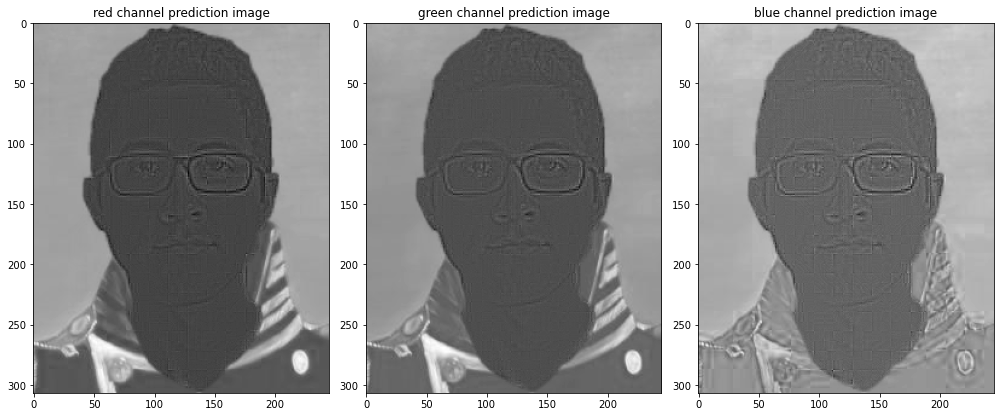

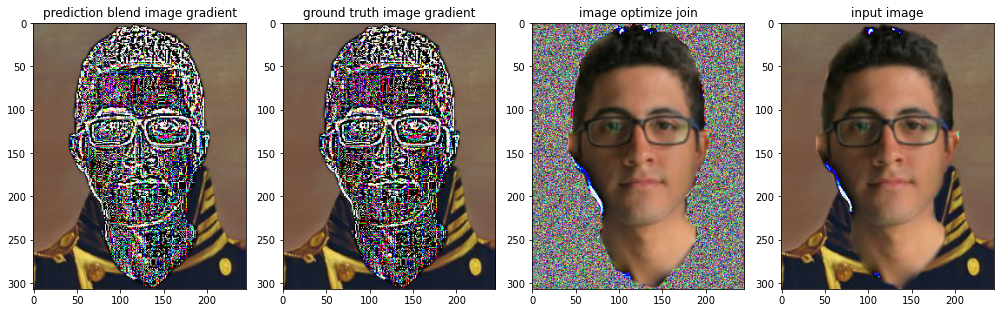

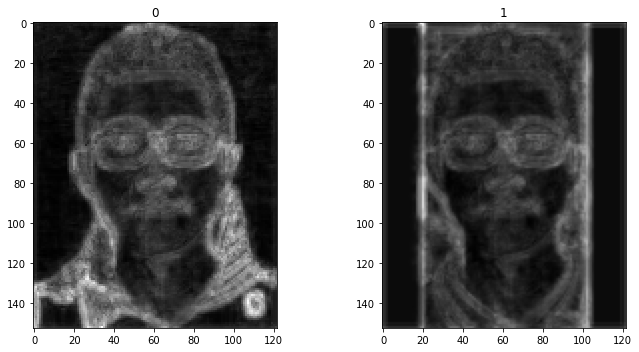

In [59]:
with torch.no_grad():
    blend_img = (input_img * mask + tensor_image_target * (1 - mask))
    blend_gradients = torch.stack(get_blending_gradients(image_data, blend_img, device=device), dim=2).squeeze(0)
    plots_multiple_tensor_image(*[blend_gradients[:, ch, :, :] for ch in range(3)],
                                title_name=["red channel prediction image",
                                           "green channel prediction image",
                                           "blue channel prediction image"], normalize=opt.normalize)
    plots_multiple_tensor_image(np.asarray(_pil_image(blend_gradients)),
                                np.asarray(_pil_image(gt_gradients)),
                                np.asarray(_pil_image(input_img)),
                                np.asarray(_pil_image(blend_img)),
                                title_name=["prediction blend image gradient",
                                           "ground truth image gradient",
                                           "image optimize join",
                                           "input image"], normalize=opt.normalize)
    plots_multiple_tensor_image(get_vgg16_features(blend_img).mean(dim=1),
                                get_vgg16_features(source).mean(dim=1), figsize=(10, 5))